In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mpld3

In [1]:
df = pd.read_csv('raw_shooter_stats.csv')

cleaned = df[
    ['Player',
     'SeasonSort table by Season in ascending order',
     'GPSort table by GP in descending order',
     'PtsSort table by Pts in descending order',
     'Shot QualitySort table by Shot Quality in descending order',
     'eFG%Sort table by eFG% in descending order',
     'TS%Sort table by TS% in descending order',
     'UsageSort table by Usage in descending order',
     'UAST2 2s PtsSort table by UAST2 2s Pts in descending order',
     'UAST3 PtsSort table by UAST3 Pts in descending order']
]

cleaned.columns = [
    'Player',
    'Season',
    'Games_Played',
    'Points',
    'Shot_Quality',
    'eFG%',
    'TS%',
    'Usage',
    'UAST2',
    'UAST3'
]

percent_cols = ['eFG%', 'TS%']
cleaned = cleaned.copy()
for col in percent_cols:
    cleaned[col] = cleaned[col].str.rstrip('%').astype(float) / 100

cleaned['Gap'] = cleaned['eFG%'] - cleaned['Shot_Quality']

cleaned['UAST_Total_Pts'] = cleaned['UAST2'] + cleaned['UAST3']
cleaned['%UAST_Pts'] = cleaned['UAST_Total_Pts'] / cleaned['Points']

cleaned['Usage'] = cleaned['Usage'] / 100

duplicates_mask = cleaned.duplicated(subset=['Player', 'Season'], keep=False)

duplicates = cleaned[duplicates_mask]
uniques = cleaned[~duplicates_mask]

idx_max_games = duplicates.groupby(['Player', 'Season'])['Games_Played'].idxmax()
combined_rows = duplicates.loc[idx_max_games]

cleaned = pd.concat([uniques, combined_rows], ignore_index=True)

cleaned = cleaned.sort_values(['Player', 'Season']).reset_index(drop=True)

players_to_analyze = [
    'Kevin Durant', 'Stephen Curry', 'Klay Thompson',
    'Tobias Harris', 'Jordan Poole',
    'Kyle Kuzma', 'Josh Giddey'
]

cleaned = cleaned[cleaned['Player'].isin(players_to_analyze)].sort_values(by="Season", ascending=True).reset_index(drop=True)
cleaned

NameError: name 'pd' is not defined

In [26]:
def head_tail_ellipsis(df, n=3):
    if len(df) <= 2 * n:
        return df.copy()
    
    top = df.head(n)
    bottom = df.tail(n)
    
    # Create a row of ellipsis with same columns as df, no index
    ellipsis_row = pd.DataFrame([["..."] * len(df.columns)], columns=df.columns)
    ellipsis_row.index = ["..."]  # set the index label for the ellipsis row
    
    # Concatenate top, ellipsis, and bottom without resetting index
    result = pd.concat([top, ellipsis_row, bottom])
    return result

preview_df = head_tail_ellipsis(cleaned, n=5)

# Convert DataFrame to HTML with inline styles and show index
html_table = preview_df.to_html(classes="preview-table", border=0, index=True)

html_full = f"""
<html>
<head>
<style>
.preview-table {{
    border-collapse: collapse;
    width: 100%;
    font-family: sans-serif;
    font-size: 16px;
    color: black;
}}

.preview-table th {{
    background-color: skyblue;
    color: black;
    padding: 12px;
    border: 1px solid #ddd;
}}

.preview-table td {{
    padding: 12px;
    border: 1px solid #ddd;
    color: black;
}}

.preview-table tr:nth-child(even) {{
    background-color: #f9f9f9;
}}

.preview-table tr:hover {{
    background-color: #f1f1f1;
}}
</style>
</head>
<body>
{html_table}
</body>
</html>
"""

# Save to file
with open("img/cleaned_preview.html", "w") as f:
    f.write(html_full)


In [5]:
""" 1. All Players in 2024–25 Bar Chart
Purpose: Benchmark all selected players against each other.

What it shows:

Kevin Durant and Stephen Curry stand out with strong positive Gaps, validating their elite status.

Klay Thompson has a lower Gap than expected, landing closer to average.

Poole, Harris, Kuzma, Giddey show more modest or negative Gaps, supporting the average or below-average classifications."""

' 1. All Players in 2024–25 Bar Chart\nPurpose: Benchmark all selected players against each other.\n\nWhat it shows:\n\nKevin Durant and Stephen Curry stand out with strong positive Gaps, validating their elite status.\n\nKlay Thompson has a lower Gap than expected, landing closer to average.\n\nPoole, Harris, Kuzma, Giddey show more modest or negative Gaps, supporting the average or below-average classifications.'

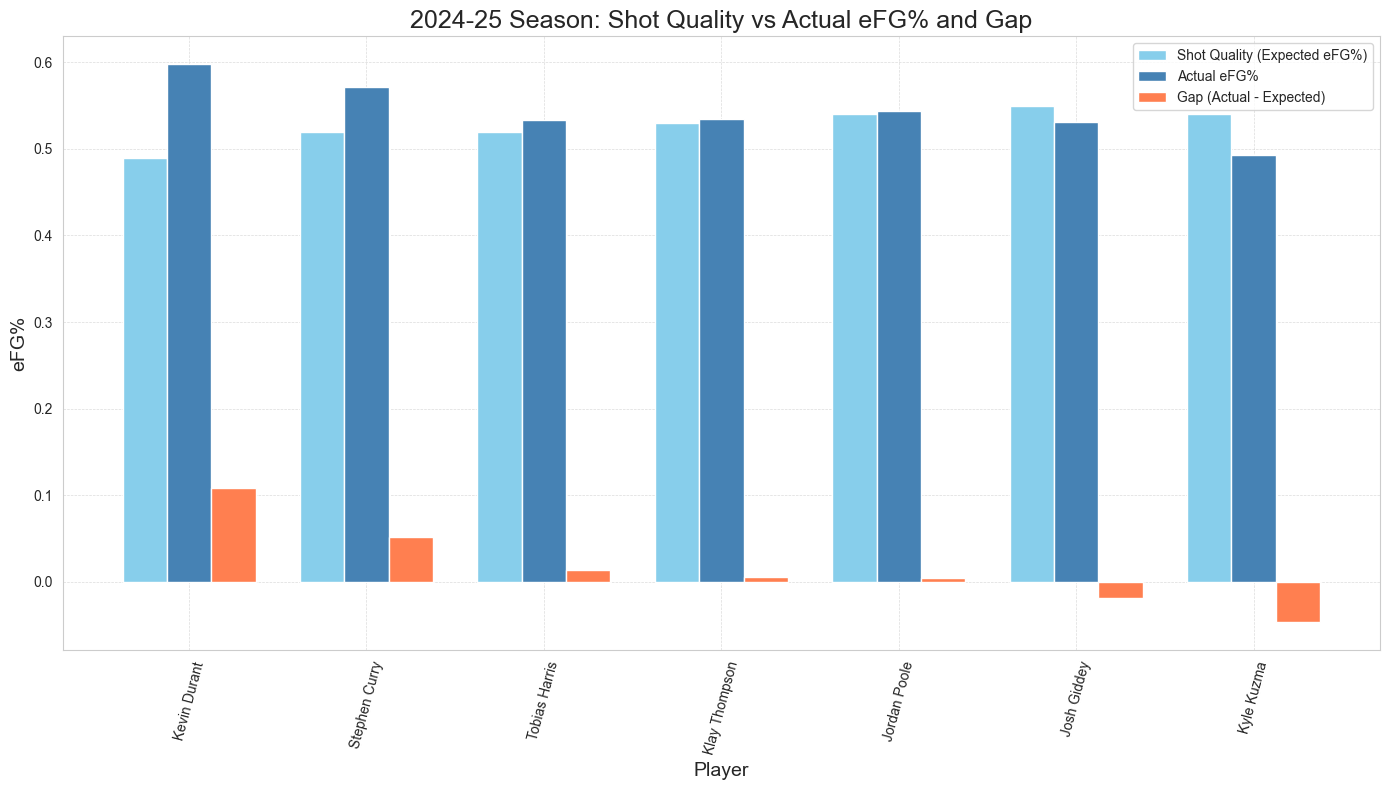

In [6]:
season_data = cleaned[cleaned['Season'] == '2024-25'].sort_values('Gap', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

bar_width = 0.25
x = np.arange(len(season_data))

plt.bar(x - bar_width, season_data['Shot_Quality'], width=bar_width, color='skyblue', edgecolor='white', label='Shot Quality (Expected eFG%)')
plt.bar(x, season_data['eFG%'], width=bar_width, color='steelblue', edgecolor='white', label='Actual eFG%')
plt.bar(x + bar_width, season_data['Gap'], width=bar_width, color='coral', edgecolor='white', label='Gap (Actual - Expected)')

plt.xticks(x, season_data['Player'], rotation=75, fontsize=10)

plt.title('2024-25 Season: Shot Quality vs Actual eFG% and Gap', fontsize=18)
plt.xlabel('Player', fontsize=14)
plt.ylabel('eFG%', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()



In [7]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=season_data['Player'],
    y=season_data['Shot_Quality'],
    name='Shot Quality (Expected eFG%)',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=season_data['Player'],
    y=season_data['eFG%'],
    name='Actual eFG%',
    marker_color='steelblue'
))
fig.add_trace(go.Bar(
    x=season_data['Player'],
    y=season_data['Gap'],
    name='Gap (Actual - Expected)',
    marker_color='coral'
))

fig.update_layout(
    barmode='group',
    xaxis_tickangle=-75,
    xaxis_title='Player',
    yaxis_title='eFG%',
    template='plotly_white',
    legend=dict(
        x=1,
        y=1,
        xanchor='right',
        yanchor='top',
        orientation='v'  # vertical stack at top right
    )
)

#fig.write_html("img/all_players_bar.html", include_plotlyjs="cdn", full_html=True)

In [8]:
""" Klay Thompson: Season-by-Season Decline
Purpose: Visualize a decline in shooting efficiency over time.

What it shows:

Early seasons: Klay overperformed his shot quality — consistent with elite shooting.

Recent seasons: The Gap shrinks or turns negative — suggesting a decline in effectiveness or shot creation quality.

Supports: Why Klay no longer classifies as elite despite reputation."""

' Klay Thompson: Season-by-Season Decline\nPurpose: Visualize a decline in shooting efficiency over time.\n\nWhat it shows:\n\nEarly seasons: Klay overperformed his shot quality — consistent with elite shooting.\n\nRecent seasons: The Gap shrinks or turns negative — suggesting a decline in effectiveness or shot creation quality.\n\nSupports: Why Klay no longer classifies as elite despite reputation.'

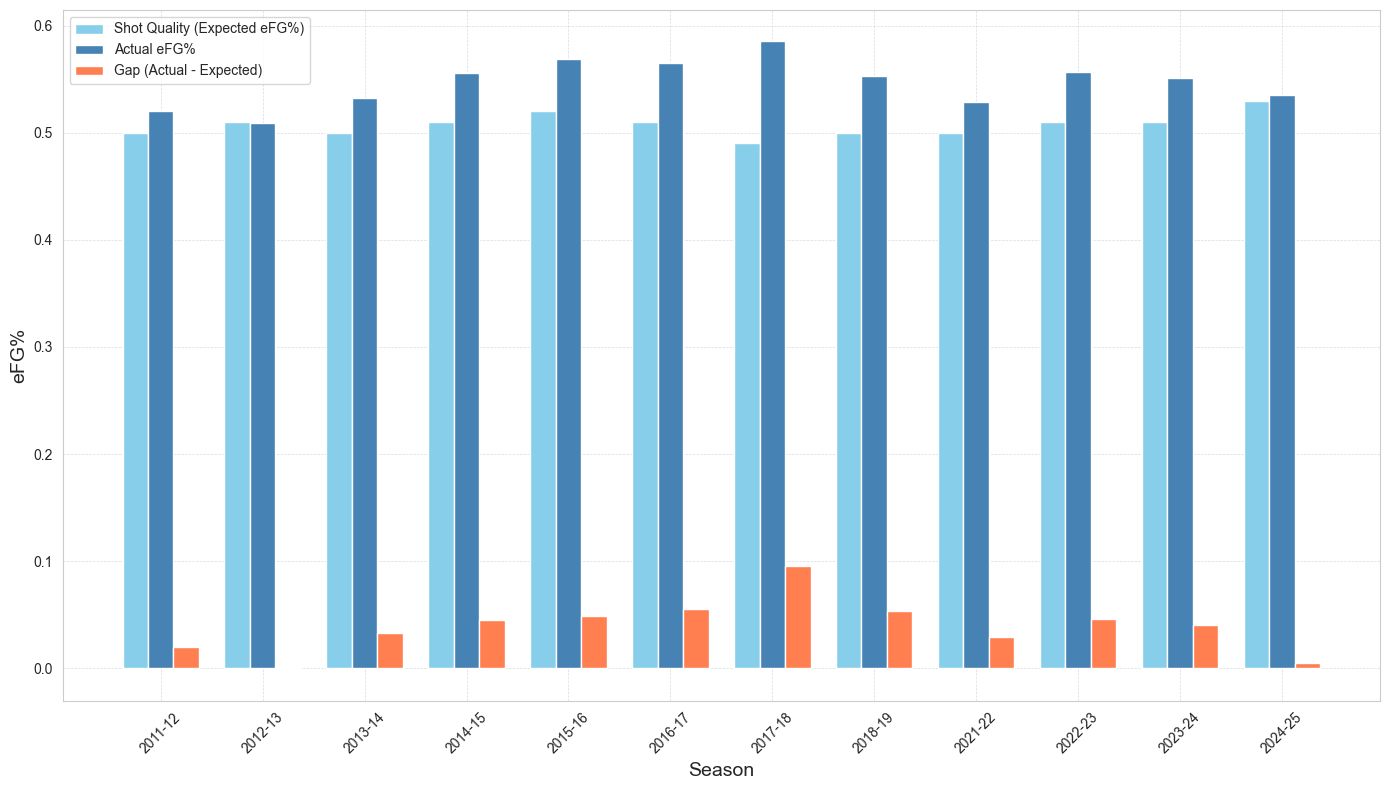

In [9]:
klay_data = cleaned[cleaned['Player'] == 'Klay Thompson'].sort_values('Season')

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

bar_width = 0.25
x = np.arange(len(klay_data))

# Plotting bars
plt.bar(x - bar_width, klay_data['Shot_Quality'], width=bar_width, color='skyblue', edgecolor='white', label='Shot Quality (Expected eFG%)')
plt.bar(x, klay_data['eFG%'], width=bar_width, color='steelblue', edgecolor='white', label='Actual eFG%')
plt.bar(x + bar_width, klay_data['Gap'], width=bar_width, color='coral', edgecolor='white', label='Gap (Actual - Expected)')

# Set X ticks as the season
plt.xticks(x, klay_data['Season'], rotation=45, fontsize=10)

# Titles and axes
plt.xlabel('Season', fontsize=14)
plt.ylabel('eFG%', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
import plotly.graph_objects as go
import numpy as np

# Sort for consistent labeling (optional)
season_data = season_data.sort_values('%UAST_Pts')

# Regression line
x_vals = season_data['%UAST_Pts']
y_vals = season_data['TS%']
slope, intercept = np.polyfit(x_vals, y_vals, 1)
reg_x = np.linspace(x_vals.min(), x_vals.max(), 100)
reg_y = slope * reg_x + intercept

# Create plot
fig = go.Figure()

# Plot all players except Jordan Poole
others = season_data[season_data['Player'] != 'Jordan Poole']
fig.add_trace(go.Scatter(
    x=others['%UAST_Pts'],
    y=others['TS%'],
    mode='markers+text',
    text=others['Player'],
    textposition='top right',
    marker=dict(color='skyblue', size=10, line=dict(color='white', width=1)),
    name='Player TS%'
))

# Plot Jordan Poole separately but without a separate legend entry
poole = season_data[season_data['Player'] == 'Jordan Poole']
fig.add_trace(go.Scatter(
    x=poole['%UAST_Pts'],
    y=poole['TS%'],
    mode='markers+text',
    text=poole['Player'],
    textposition='middle left',
    marker=dict(color='skyblue', size=10, line=dict(color='white', width=1)),
    showlegend=False  # don't show Jordan Poole separately in legend
))

# Regression line
fig.add_trace(go.Scatter(
    x=reg_x,
    y=reg_y,
    mode='lines',
    line=dict(color='coral', width=2, dash='dash'),
    name='Regression Line',
    hoverinfo='skip'
))

# Layout
fig.update_layout(
    xaxis_title='Self-Created Scoring Rate (% of Unassisted Points)',
    yaxis_title='True Shooting % (TS%)',
    template='plotly_white',
    legend=dict(
        x=1,
        y=1.0,
        xanchor='right',
        yanchor='top',
        orientation='v'  # stacked legend
    ),
    margin=dict(l=50, r=100, t=50, b=50),
    height=600,
    width=900
)

# Save as HTML
fig.write_html("img/self_created_scatter.html", include_plotlyjs="cdn", full_html=True)


In [11]:
""" Kevin Durant: Consistent Elite Shooting
Purpose: Showcase sustained overperformance relative to shot quality.

What it shows:

Almost every season has a strong positive Gap, even improving in later years.

Indicates Durant isn’t just taking quality shots — he’s converting at an exceptional rate year after year.

Supports: Your claim that Durant is clearly elite, both in expected and actual output."""



' Kevin Durant: Consistent Elite Shooting\nPurpose: Showcase sustained overperformance relative to shot quality.\n\nWhat it shows:\n\nAlmost every season has a strong positive Gap, even improving in later years.\n\nIndicates Durant isn’t just taking quality shots — he’s converting at an exceptional rate year after year.\n\nSupports: Your claim that Durant is clearly elite, both in expected and actual output.'

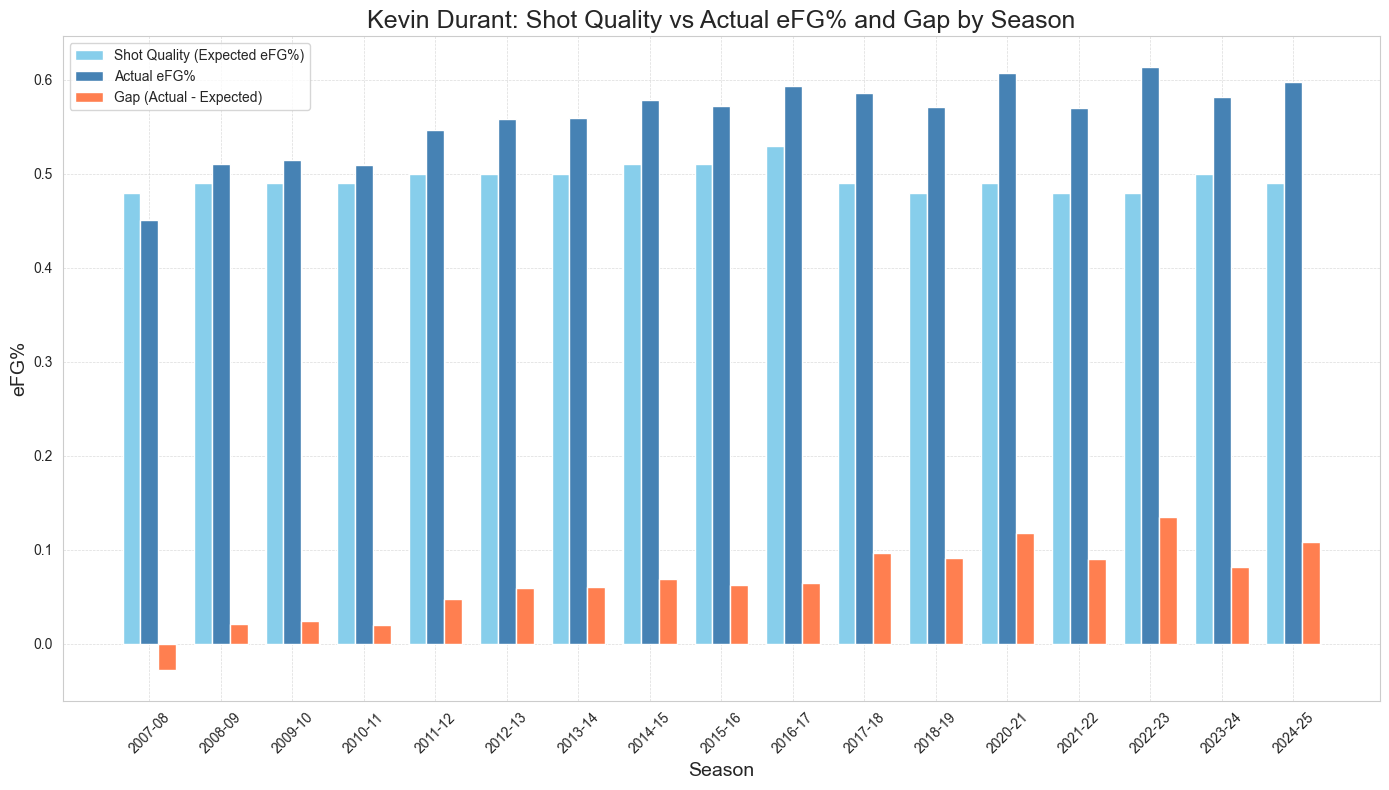

In [12]:
kd_data = cleaned[cleaned['Player'] == 'Kevin Durant'].sort_values('Season')

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

bar_width = 0.25
x = np.arange(len(kd_data))

# Plotting bars
plt.bar(x - bar_width, kd_data['Shot_Quality'], width=bar_width, color='skyblue', edgecolor='white', label='Shot Quality (Expected eFG%)')
plt.bar(x, kd_data['eFG%'], width=bar_width, color='steelblue', edgecolor='white', label='Actual eFG%')
plt.bar(x + bar_width, kd_data['Gap'], width=bar_width, color='coral', edgecolor='white', label='Gap (Actual - Expected)')

# Set X ticks as the season
plt.xticks(x, kd_data['Season'], rotation=45, fontsize=10)

# Titles and axes
plt.title('Kevin Durant: Shot Quality vs Actual eFG% and Gap by Season', fontsize=18)
plt.xlabel('Season', fontsize=14)
plt.ylabel('eFG%', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
"""2024–25 Shot Quality vs Actual eFG% Scatter Plot
Purpose: Visualize how players’ expected shooting quality compares to their actual shooting efficiency.

What it shows:
Each point represents a player’s expected shot quality (x-axis) versus their actual effective field goal percentage (y-axis) in the 2024–25 season.

The dashed orange line (y = x) represents perfect alignment — where actual performance matches expected shot quality exactly.

Players above this line outperform expectations, making tougher shots or being more efficient than the quality of their looks suggests. Players below the line underperform their shot quality.

Annotations for every player make it easy to identify who consistently exceeds or falls short of their expected shooting efficiency.

Overall, elite shooters like Kevin Durant and Stephen Curry are clearly above the line, confirming their ability to surpass shot quality metrics, while others cluster closer to or below the line."""

'2024–25 Shot Quality vs Actual eFG% Scatter Plot\nPurpose: Visualize how players’ expected shooting quality compares to their actual shooting efficiency.\n\nWhat it shows:\nEach point represents a player’s expected shot quality (x-axis) versus their actual effective field goal percentage (y-axis) in the 2024–25 season.\n\nThe dashed orange line (y = x) represents perfect alignment — where actual performance matches expected shot quality exactly.\n\nPlayers above this line outperform expectations, making tougher shots or being more efficient than the quality of their looks suggests. Players below the line underperform their shot quality.\n\nAnnotations for every player make it easy to identify who consistently exceeds or falls short of their expected shooting efficiency.\n\nOverall, elite shooters like Kevin Durant and Stephen Curry are clearly above the line, confirming their ability to surpass shot quality metrics, while others cluster closer to or below the line.'

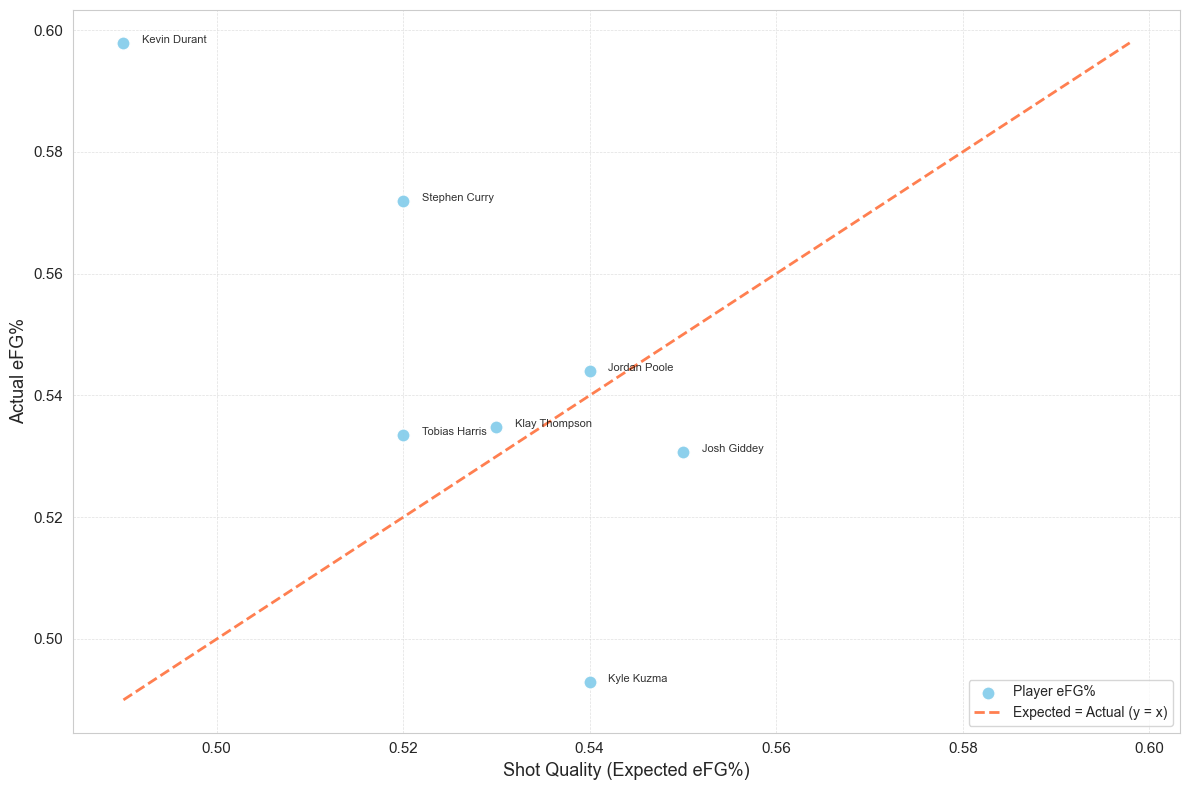

In [14]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot scatter points (Actual vs Expected)
plt.scatter(
    season_data['Shot_Quality'],
    season_data['eFG%'],
    color='skyblue',
    edgecolor='white',
    s=90,
    alpha=0.95,
    zorder=3,
    label='Player eFG%'
)

# Reference line: y = x (Expected = Actual)
min_val = min(season_data['Shot_Quality'].min(), season_data['eFG%'].min())
max_val = max(season_data['Shot_Quality'].max(), season_data['eFG%'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='coral', linewidth=2, label='Expected = Actual (y = x)', zorder=1)

# Annotate all players
for _, row in season_data.iterrows():
    plt.text(
        row['Shot_Quality'] + 0.002,  # x-offset for clarity
        row['eFG%'],
        row['Player'],
        fontsize=8,
        color='black',
        alpha=0.8
    )

# Title and axes
plt.xlabel('Shot Quality (Expected eFG%)', fontsize=13)
plt.ylabel('Actual eFG%', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Legend and grid
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


In [15]:
import plotly.graph_objects as go

min_val = min(season_data['Shot_Quality'].min(), season_data['eFG%'].min())
max_val = max(season_data['Shot_Quality'].max(), season_data['eFG%'].max())

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=season_data['Shot_Quality'],
    y=season_data['eFG%'],
    mode='markers+text',
    text=season_data['Player'],
    textposition='top right',
    marker=dict(color='skyblue', size=10, line=dict(color='white', width=1)),
    name='Player eFG%'
))

fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='coral', dash='dash', width=2),
    name='Expected = Actual (y = x)',
    hoverinfo='skip'
))

fig.update_layout(
    xaxis_title='Shot Quality (Expected eFG%)',
    yaxis_title='Actual eFG%',
    template='plotly_white',
    legend=dict(
        x=1,            # right edge
        y=1.0,          # top
        xanchor='right', # anchor legend’s right side at x=1
        yanchor='top',   # anchor legend’s top at y=1
        orientation='h'
    ),
    margin=dict(l=50, r=50, t=40, b=50),
    height=600,
    width=900
)

#fig.write_html("img/all_players_scatter.html", include_plotlyjs="cdn", full_html=True)


In [16]:
"""2024–25: Self-Created Offense vs. Scoring Efficiency
Purpose: Explore the relationship between players’ ability to generate their own scoring opportunities (% of unassisted points) and their overall scoring efficiency (True Shooting Percentage).

What it shows:
Each dot represents a player’s rate of self-created scoring — the proportion of their points scored without an assist — plotted against their true shooting percentage (TS%).

The dashed orange regression line highlights the overall trend, showing how changes in self-created scoring relate to scoring efficiency.

Annotations identify individual players, revealing how prolific scorers like Kevin Durant and Stephen Curry balance creating their own shots with maintaining high efficiency.

This visualization helps answer whether players who work harder to create their own offense can sustain elite scoring efficiency or if reliance on assisted opportunities yields better TS%."""

'2024–25: Self-Created Offense vs. Scoring Efficiency\nPurpose: Explore the relationship between players’ ability to generate their own scoring opportunities (% of unassisted points) and their overall scoring efficiency (True Shooting Percentage).\n\nWhat it shows:\nEach dot represents a player’s rate of self-created scoring — the proportion of their points scored without an assist — plotted against their true shooting percentage (TS%).\n\nThe dashed orange regression line highlights the overall trend, showing how changes in self-created scoring relate to scoring efficiency.\n\nAnnotations identify individual players, revealing how prolific scorers like Kevin Durant and Stephen Curry balance creating their own shots with maintaining high efficiency.\n\nThis visualization helps answer whether players who work harder to create their own offense can sustain elite scoring efficiency or if reliance on assisted opportunities yields better TS%.'

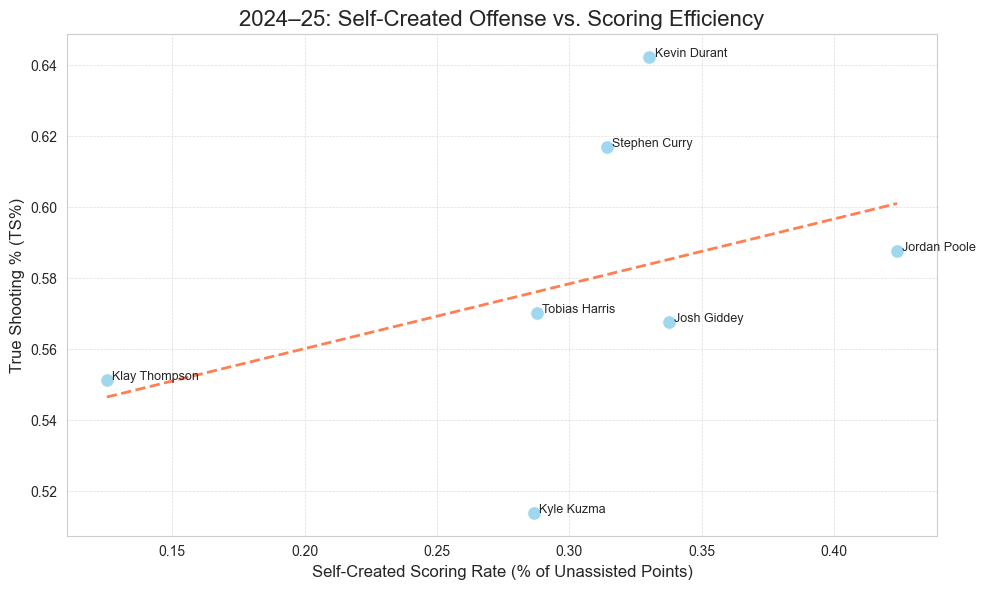

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Scatterplot with regression line
sns.regplot(
    data=season_data,
    x='%UAST_Pts',
    y='TS%',
    scatter=True,
    ci=None,  # no confidence interval
    scatter_kws={'s': 100, 'edgecolor': 'white', 'color': 'skyblue'},  # skyblue dots with white edges
    line_kws={'color': 'coral', 'linewidth': 2, 'linestyle': '--'}   # orange dashed regression line
)

# Annotate player names
for _, row in season_data.iterrows():
    plt.text(row['%UAST_Pts'] + 0.002, row['TS%'], row['Player'], fontsize=9)

plt.xlabel('Self-Created Scoring Rate (% of Unassisted Points)', fontsize=12)
plt.ylabel('True Shooting % (TS%)', fontsize=12)
plt.title('2024–25: Self-Created Offense vs. Scoring Efficiency', fontsize=16)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:
import plotly.graph_objects as go
import numpy as np

# Sort for consistent labeling (optional)
season_data = season_data.sort_values('%UAST_Pts')

# Regression line
x_vals = season_data['%UAST_Pts']
y_vals = season_data['TS%']
slope, intercept = np.polyfit(x_vals, y_vals, 1)
reg_x = np.linspace(x_vals.min(), x_vals.max(), 100)
reg_y = slope * reg_x + intercept

# Create plot
fig = go.Figure()

# Separate Poole from the rest
poole_data = season_data[season_data['Player'] == 'Jordan Poole']
others = season_data[season_data['Player'] != 'Jordan Poole']

# Scatter for everyone else
fig.add_trace(go.Scatter(
    x=others['%UAST_Pts'],
    y=others['TS%'],
    mode='markers+text',
    text=others['Player'],
    textposition='top right',
    marker=dict(
        color='skyblue',
        size=10,
        line=dict(color='white', width=1)
    ),
    name='Players'
))

# Separate scatter for Jordan Poole, with label to the left
fig.add_trace(go.Scatter(
    x=poole_data['%UAST_Pts'],
    y=poole_data['TS%'],
    mode='markers+text',
    text=poole_data['Player'],
    textposition='middle left',
    marker=dict(
        color='skyblue',
        size=10,
        line=dict(color='white', width=1)
    ),
    name='Jordan Poole'
))

# Regression line
fig.add_trace(go.Scatter(
    x=reg_x,
    y=reg_y,
    mode='lines',
    line=dict(color='coral', width=2, dash='dash'),
    name='Regression Line',
    hoverinfo='skip'
))

# Layout with vertical stacked legend
fig.update_layout(
    title='2024–25: Self-Created Offense vs. Scoring Efficiency',
    xaxis_title='Self-Created Scoring Rate (% of Unassisted Points)',
    yaxis_title='True Shooting % (TS%)',
    template='plotly_white',
    legend=dict(
        x=1,
        y=1.0,
        xanchor='right',
        yanchor='top',
        orientation='v'  # stack vertically
    ),
    margin=dict(l=50, r=100, t=50, b=50),
    height=600,
    width=900
)

# Save to HTML file
#fig.write_html("img/self_created_scatter.html", include_plotlyjs="cdn", full_html=True)


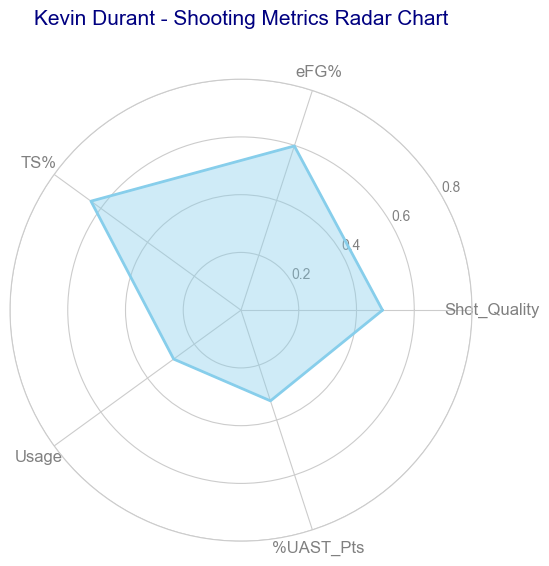

In [19]:
# Filter Kevin Durant's most recent season or any specific season you want
kd_data = cleaned[cleaned['Player'] == 'Kevin Durant'].iloc[-1]

# Metrics to plot
categories = ['Shot_Quality', 'eFG%', 'TS%', 'Usage', '%UAST_Pts']

# Extract values for the radar chart
values = kd_data[categories].values.flatten().tolist()

# Close the circle by appending the first value to the end
values += values[:1]

# Number of variables we're plotting
num_vars = len(categories)

# Calculate angle for each axis in the plot (in radians)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Setup the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, .8)

# Plot data
ax.plot(angles, values, color='skyblue', linewidth=2, linestyle='solid')

# Fill area
ax.fill(angles, values, color='skyblue', alpha=0.4)

# Title
plt.title('Kevin Durant - Shooting Metrics Radar Chart', size=15, color='navy', y=1.1)

plt.show()


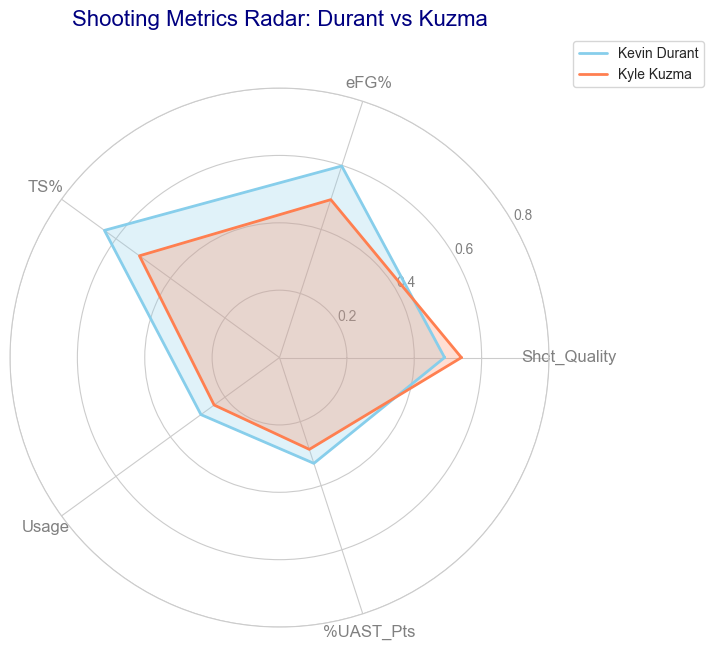

In [20]:
import matplotlib.pyplot as plt
import numpy as np

players = ['Kevin Durant', 'Kyle Kuzma']
categories = ['Shot_Quality', 'eFG%', 'TS%', 'Usage', '%UAST_Pts']
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories, color='grey', size=12)
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, .8)

colors = ['skyblue', 'coral']

power = 1  # tweak this between 1 and 3

for i, player in enumerate(players):
    player_data = cleaned[cleaned['Player'] == player].iloc[-1]
    values = player_data[categories].values.flatten()
    
    # Apply power transform to exaggerate differences
    values = np.power(values, power)
    values = np.clip(values, 0, 1)  # keep within radar limits
    values = values.tolist()
    
    values += values[:1]

    ax.plot(angles, values, color=colors[i], linewidth=2, linestyle='solid', label=player)
    ax.fill(angles, values, color=colors[i], alpha=0.25)

plt.title('Shooting Metrics Radar: Durant vs Kuzma', size=16, color='navy', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


In [21]:
import plotly.graph_objects as go
import numpy as np

players = ['Kevin Durant', 'Kyle Kuzma']
categories = ['Shot_Quality', 'eFG%', 'TS%', 'Usage', '%UAST_Pts']

fig = go.Figure()

colors = ['skyblue', 'coral']
power = 1  # tweak between 1 and 3

for i, player in enumerate(players):
    player_data = cleaned[cleaned['Player'] == player].iloc[-1]
    values = player_data[categories].values.flatten()
    
    # Apply power transform to exaggerate differences
    values = np.power(values, power)
    values = np.clip(values, 0, 1)  # clip to [0,1]
    values = values.tolist()
    
    # close the loop
    values += values[:1]
    categories_loop = categories + categories[:1]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories_loop,
        fill='toself',
        name=player,
        line=dict(color=colors[i]),
        opacity=0.5
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 0.8],
            tickvals=[0.2, 0.4, 0.6, 0.8],
            ticktext=["0.2", "0.4", "0.6", "0.8"],
        ),
    ),
    showlegend=True,
    title_x=0.5,
    height=700,
    width=700,
    template="plotly_white"
)

#fig.write_html("img/durant_kuzma_radar.html", include_plotlyjs="cdn", full_html=True)

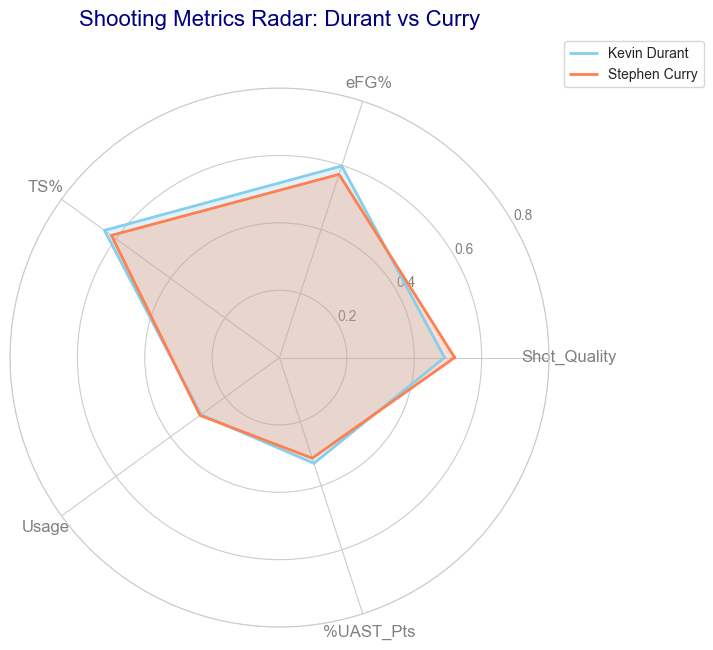

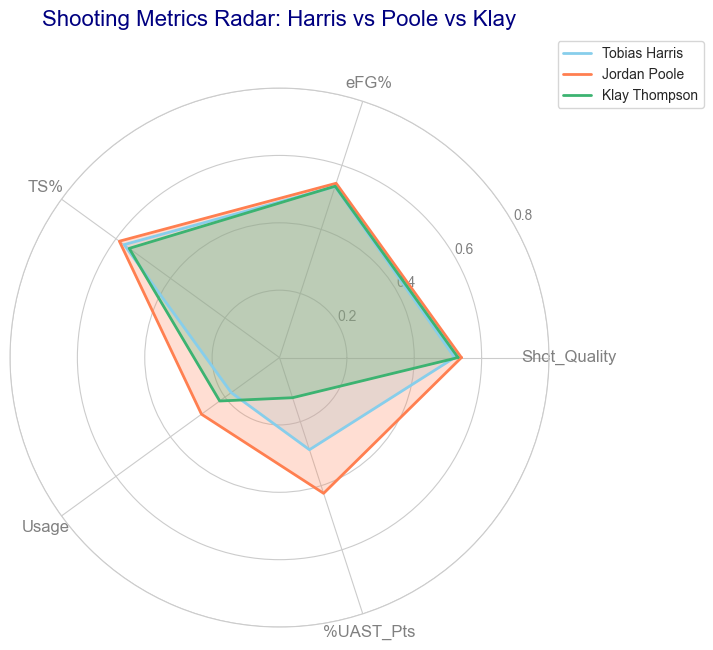

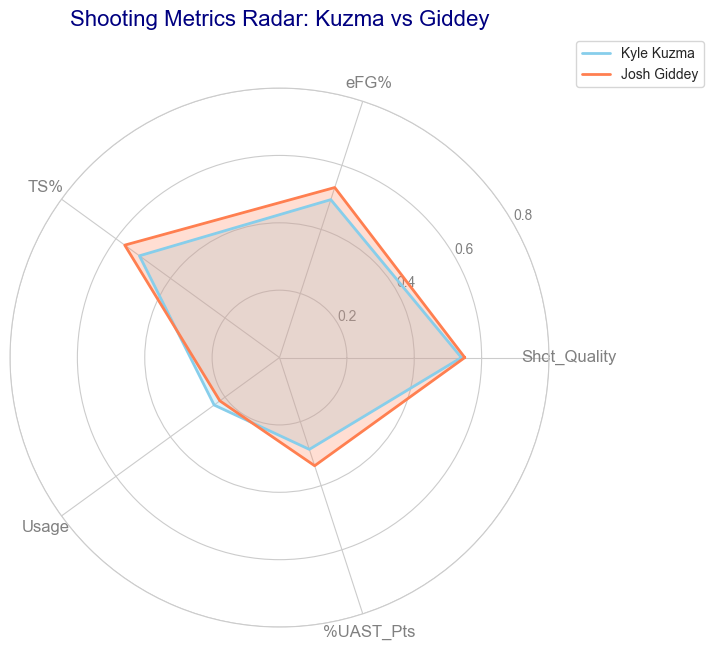

In [22]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Shot_Quality', 'eFG%', 'TS%', 'Usage', '%UAST_Pts']
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

power = 1  # exaggeration factor for differences
colors_groups = [
    ['skyblue', 'coral'],
    ['skyblue', 'coral', 'mediumseagreen'],
    ['skyblue', 'coral']
]

player_groups = [
    ['Kevin Durant', 'Stephen Curry'],
    ['Tobias Harris', 'Jordan Poole', 'Klay Thompson'],
    ['Kyle Kuzma', 'Josh Giddey']
]

titles = [
    'Shooting Metrics Radar: Durant vs Curry',
    'Shooting Metrics Radar: Harris vs Poole vs Klay',
    'Shooting Metrics Radar: Kuzma vs Giddey'
]

for idx, players in enumerate(player_groups):
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, .8)

    colors = colors_groups[idx]

    for i, player in enumerate(players):
        player_data = cleaned[cleaned['Player'] == player].iloc[-1]
        values = player_data[categories].values.flatten()
        values = np.power(values, power)
        values = np.clip(values, 0, 1)
        values = values.tolist()
        values += values[:1]

        ax.plot(angles, values, color=colors[i], linewidth=2, linestyle='solid', label=player)
        ax.fill(angles, values, color=colors[i], alpha=0.25)

    plt.title(titles[idx], size=16, color='navy', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()


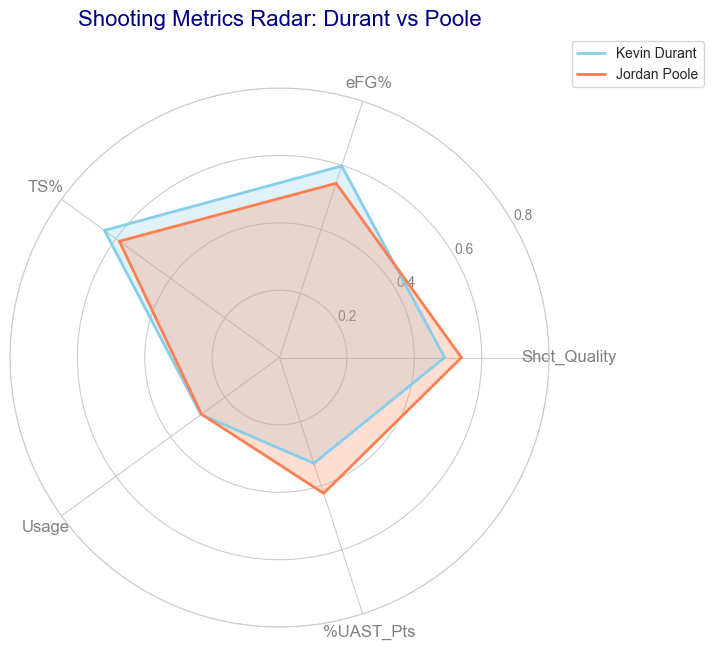

In [23]:
import matplotlib.pyplot as plt
import numpy as np

players = ['Kevin Durant', 'Jordan Poole']
categories = ['Shot_Quality', 'eFG%', 'TS%', 'Usage', '%UAST_Pts']
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories, color='grey', size=12)
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, .8)

colors = ['skyblue', 'coral']

power = 1  # tweak this between 1 and 3

for i, player in enumerate(players):
    player_data = cleaned[cleaned['Player'] == player].iloc[-1]
    values = player_data[categories].values.flatten()
    
    # Apply power transform to exaggerate differences
    values = np.power(values, power)
    values = np.clip(values, 0, 1)  # keep within radar limits
    values = values.tolist()
    
    values += values[:1]

    ax.plot(angles, values, color=colors[i], linewidth=2, linestyle='solid', label=player)
    ax.fill(angles, values, color=colors[i], alpha=0.25)

plt.title('Shooting Metrics Radar: Durant vs Poole', size=16, color='navy', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


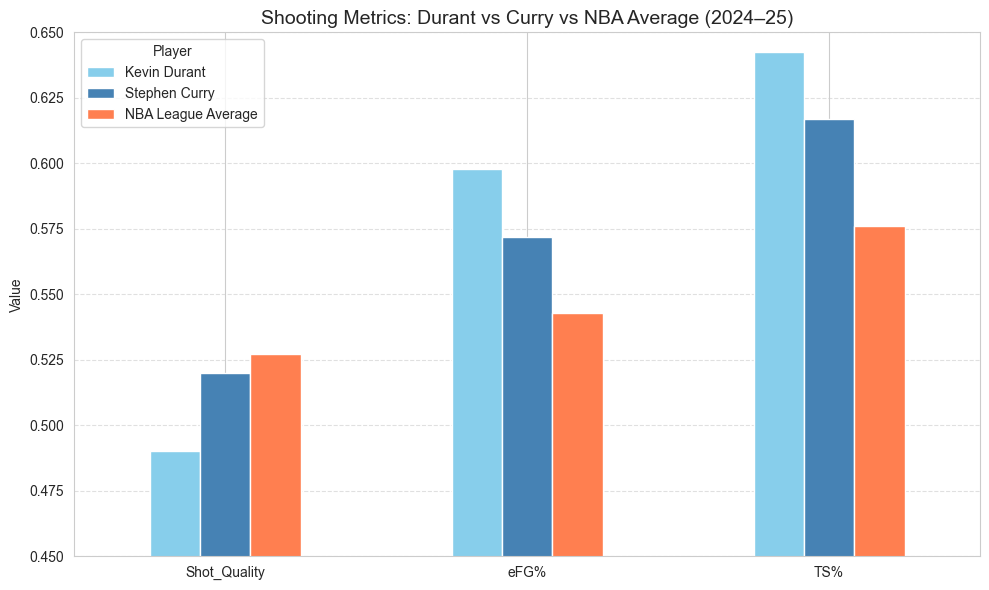

In [24]:
# Filter for 2024–25 season
season_data = cleaned[cleaned['Season'] == '2024-25']

# Compute average Shot Quality only
avg_shot_quality = season_data['Shot_Quality'].mean().round(4)

# Define official league averages
league_efg = 0.543
league_ts = 0.576

# Extract KD and Curry's stats for 2024–25
players = ['Kevin Durant', 'Stephen Curry']
player_stats = cleaned[(cleaned['Player'].isin(players)) & (cleaned['Season'] == '2024-25')].copy()
player_stats = player_stats[['Player', 'Shot_Quality', 'eFG%', 'TS%']].set_index('Player').round(4)

# Append league averages row
league_row = pd.DataFrame({
    'Shot_Quality': [avg_shot_quality],
    'eFG%': [league_efg],
    'TS%': [league_ts]
}, index=['NBA League Average'])

# Combine all
comparison_df = pd.concat([player_stats, league_row])


comparison_df.T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'steelblue', 'coral'])
plt.title('Shooting Metrics: Durant vs Curry vs NBA Average (2024–25)', fontsize=14)
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.ylim(.45, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Player')
plt.tight_layout()
plt.show()

In [25]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'cleaned' DataFrame is already loaded and available

# Filter for 2024–25 season
season_data = cleaned[cleaned['Season'] == '2024-25']

# Compute average Shot Quality only
avg_shot_quality = season_data['Shot_Quality'].mean().round(4)

# Define official league averages
league_efg = 0.543
league_ts = 0.576

# Extract KD and Curry's stats for 2024–25
players = ['Kevin Durant', 'Stephen Curry']
player_stats = cleaned[(cleaned['Player'].isin(players)) & (cleaned['Season'] == '2024-25')].copy()
player_stats = player_stats[['Player', 'Shot_Quality', 'eFG%', 'TS%']].set_index('Player').round(4)

# Append league averages row
league_row = pd.DataFrame({
    'Shot_Quality': [avg_shot_quality],
    'eFG%': [league_efg],
    'TS%': [league_ts]
}, index=['NBA League Average'])

# Combine all
comparison_df = pd.concat([player_stats, league_row])

# Transpose for plotting
comparison_df_T = comparison_df.T

# Create Plotly figure
fig = go.Figure()

colors = ['skyblue', 'steelblue', 'coral']  # colors for KD, Curry, League Avg
players_order = comparison_df_T.columns.tolist()

for i, player in enumerate(players_order):
    fig.add_trace(go.Bar(
        x=comparison_df_T.index,
        y=comparison_df_T[player],
        name=player,
        marker_color=colors[i]
    ))

fig.update_layout(
    yaxis=dict(title='Value', range=[0.45, 0.65], gridcolor='LightGrey', zeroline=False),
    xaxis=dict(title='Metric'),
    barmode='group',
    legend=dict(
    x=0,
    y=1,
    xanchor='left',
    yanchor='top',
    orientation='v'  # vertical stack
    ),
    legend_title_text='Player',
    template='plotly_white',
    height=500,
    width=800,
)

#fig.write_html("img/durant_curry_league_bar.html", include_plotlyjs="cdn", full_html=True)
